<a href="https://colab.research.google.com/github/pavelpryadokhin/Classification/blob/main/News_classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Классификации новостей по заголовкам

Создадим модель для классификации заголовков, которая сможет определять тематику статьи.

In [ ]:
!unzip -qo "lenta-ru-news.csv.zip" -d ./dataset

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


#Подготовка данных

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot

import keras
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from kerastuner.tuners import RandomSearch,Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
address = "./dataset/lenta-ru-news.csv"
df = pd.read_csv(address , sep=',')
df = df.dropna()


<ipython-input-37-8227f0ee019f>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(address , sep=',')


In [ ]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


Избавимся от дубликатов.

In [ ]:
print(df.shape) #до отчистки
df = df.drop(['url','text','tags'], axis = 1)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year >= 2000]
df= df.drop(['date'], axis = 1)
df.drop_duplicates(subset=['title'], inplace = True)
df.shape #после отчистки

(712654, 6)


(706961, 2)

In [ ]:
df.head()

,title,topic
3086,Ошибка 2000: ничего не случилось,Интернет и СМИ
3087,В новогоднюю ночь ликвидировано семь полевых к...,Россия
3088,Путин: в составе правительства возможны изменения,Россия
3089,Патриарх Всея Руси прибыл на Святую Землю,Россия
3090,Фонду Ельцина выделят помещение в Кремле,Россия


In [ ]:
df['topic'].unique()

array(['Интернет и СМИ', 'Россия', 'Мир', 'Экономика', 'Спорт',
       'Культура', 'Из жизни', 'Наука и техника', 'Бывший СССР', 'Дом',
       'Сочи', 'ЧМ-2014', 'Путешествия', 'Библиотека',
       'Силовые структуры', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
       'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

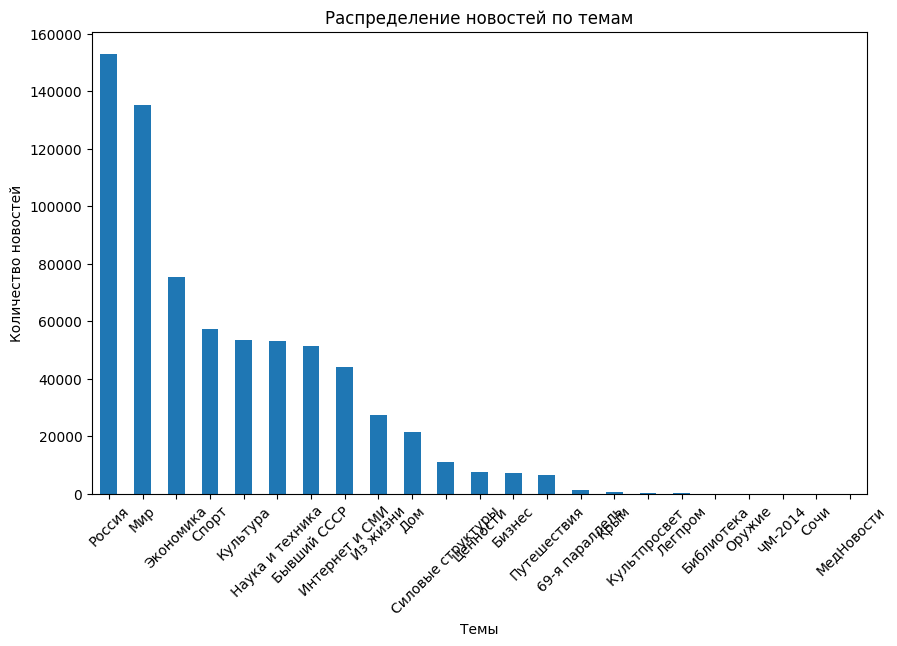

In [ ]:
topic_counts = df['topic'].value_counts()

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Распределение новостей по темам')
plt.xlabel('Темы')
plt.ylabel('Количество новостей')
plt.xticks(rotation=45)
plt.show()

Отберем 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов

In [ ]:
topic_counts = df['topic'].value_counts().items()

topic_dict = dict()
num_class = 10
for ind,(key, val) in enumerate(sorted(topic_counts,key=lambda item: item[1],reverse=True)[:num_class-1]):
    topic_dict[key]=ind
topic_dict['other']=num_class-1
reverse_topic_dict=dict((val,key) for key,val in topic_dict.items())
topic_dict

{'Россия': 0,
 'Мир': 1,
 'Экономика': 2,
 'Спорт': 3,
 'Культура': 4,
 'Наука и техника': 5,
 'Бывший СССР': 6,
 'Интернет и СМИ': 7,
 'Из жизни': 8,
 'other': 9}

In [ ]:
df['topic'] = df['topic'].apply(lambda x: topic_dict[x] if x in topic_dict else topic_dict['other'])

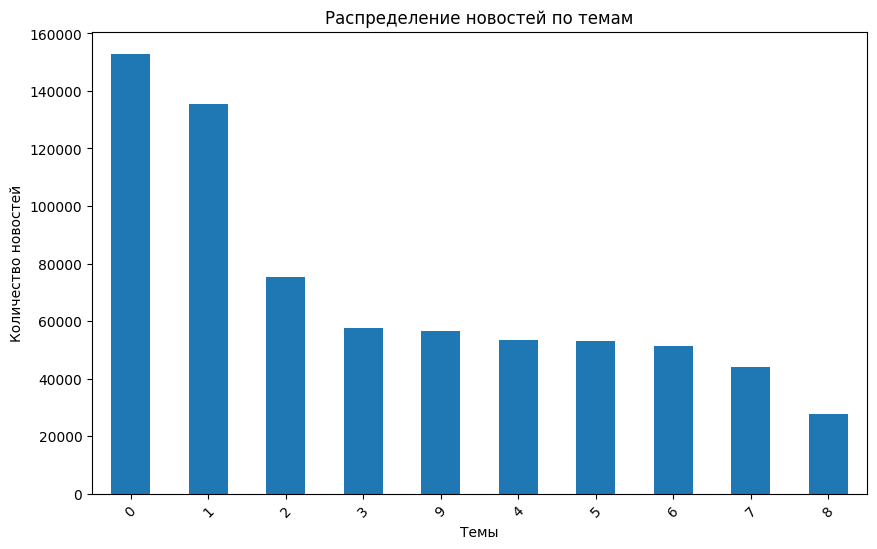

In [ ]:
topic_counts = df['topic'].value_counts()

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Распределение новостей по темам')
plt.xlabel('Темы')
plt.ylabel('Количество новостей')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# сбалансируем классы
max_objects = 60000

df_sampled = df.groupby('topic').apply(lambda x: x.sample(min(len(x), max_objects), random_state=42))
df_sampled = df_sampled.reset_index(drop=True)

<ipython-input-46-101ab3d76eb2>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('topic').apply(lambda x: x.sample(min(len(x), max_objects), random_state=42))


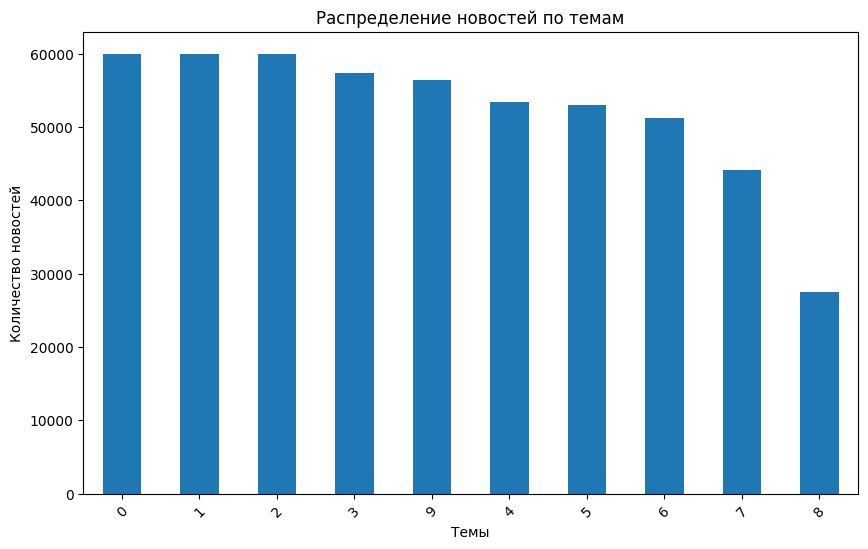

In [ ]:
topic_counts = df_sampled['topic'].value_counts()

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Распределение новостей по темам')
plt.xlabel('Темы')
plt.ylabel('Количество новостей')
plt.xticks(rotation=45)
plt.show()

In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_sampled.title),
                                                  np.array(df_sampled.topic),
                                                  test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (366200,)
Форма выходных меток:  (366200,)
Пример заголовка:  Wired News удалили фальшивые интервью


In [ ]:
del df_sampled, X_tmp, y_tmp, df

In [ ]:
# Задаем размер словаря
vocab_size = 10000

# Выравниваем входные последовательности до заданной длины
sentence_len = 25

def data_preparation(data):
    corpus=[]
    for text in data:
        text = re.sub("[^а-яА-ЯёЁa-zA-Z]", " ", text)
        text=text.lower()
        text=text.split()
        text=" ".join(text)
        corpus.append(text)

    oneHot_doc=[one_hot(input_text=words, n=vocab_size) for words in corpus]
    embedded_doc=pad_sequences(sequences=oneHot_doc, maxlen=sentence_len, padding="post")
    return embedded_doc

In [ ]:
X_train[0]

'Wired News удалили фальшивые интервью'

In [ ]:
# Запускаем предобработку данных
train_data = data_preparation(X_train)
val_data = data_preparation(X_val)
test_data = data_preparation(X_test)
train_data[0]

array([1226, 2898,  707, 3485, 3470,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=num_class)
y_val_one_hot = to_categorical(y_val, num_classes=num_class)
y_test_one_hot = to_categorical(y_test, num_classes=num_class)

#Обучение модели

In [ ]:
# Определение функции для построения модели
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Embedding(input_dim=vocab_size,
      output_dim=hp.Int('embedding_dim', min_value=8, max_value=32, step=8)))
    model.add(layers.GlobalAveragePooling1D())

    # Задаем количество слоев и их параметры
    for i in range(hp.Int('num_layers', 1, 2)):  # число слоев
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 96, 256, 32),  # размерность
                               activation=hp.Choice('activation_' + str(i), ['relu', 'leaky_relu'])))  # функция активации

    for i in range(hp.Int('num_layers', 1, 2)):  # число слоев
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 96, 16),  # размерность
                               activation=hp.Choice('activation_' + str(i), ['relu', 'leaky_relu'])))  # функция активации

    model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), 0.0, 0.2, 0.1)))
    model.add(layers.Dense(num_class, activation='softmax'))  # Выходной слой

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [ ]:
# Определение гиперпараметров для настройки
tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=10,
                            directory='output')

# tuner_search = Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=20,  # Максимальное количество эпох обучения
#     factor=3,  # Уменьшение количества моделей на каждом этапе
#     directory='output',
#     project_name='hyperband_tuner',  # Имя проекта
# )

# Запуск настройки гиперпараметров
tuner_search.search(train_data, y_train_one_hot, epochs=5, validation_data=(val_data,y_val_one_hot))

# Получение наилучшей модели
best_model = tuner_search.get_best_models(num_models=1)[0]

# Оценка наилучшей модели на тестовых данных
test_loss, test_accuracy = best_model.evaluate(test_data, y_test_one_hot)
print('Test accuracy:', test_accuracy)

Trial 10 Complete [00h 02m 35s]
val_accuracy: 0.5751169323921204

Best val_accuracy So Far: 0.6386181116104126
Total elapsed time: 00h 30m 55s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2453/2453 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6452 - loss: 1.0901
Test accuracy: 0.6431083679199219


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 25, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 224)                 │          43,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 224)                 │          43,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,250 (1.75 MB)

 Trainable params: 458,250 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

#Результат

In [ ]:
def softmax(logits):
    exp_preds = np.exp(logits)
    probabilities = exp_preds / np.sum(exp_preds, axis=-1,keepdims=True)
    return np.argmax(probabilities, axis=-1)

def replace(indices):
    return [reverse_topic_dict[index] for index in indices]


#Предсказание на лучшей модели
predicted_y = best_model.predict(test_data)

print(classification_report(replace(y_test), replace(softmax(predicted_y))))

2453/2453 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                 precision    recall  f1-score   support

          other       0.62      0.49      0.55      8495
    Бывший СССР       0.66      0.80      0.72      7875
       Из жизни       0.43      0.42      0.42      4101
 Интернет и СМИ       0.62      0.56      0.59      6429
       Культура       0.62      0.72      0.67      7929
            Мир       0.65      0.56      0.60      9122
Наука и техника       0.66      0.71      0.68      7884
         Россия       0.56      0.50      0.53      9025
          Спорт       0.82      0.87      0.84      8654
      Экономика       0.65      0.70      0.68      8958

       accuracy                           0.64     78472
      macro avg       0.63      0.63      0.63     78472
   weighted avg       0.64      0.64      0.64     78472



С помощью случайных выборов гиперпараметров нам удалось достичь точности в 64%.  Видим, что лучше всего модель справляется с темой спорт, точность составляет порядка 82%. В то время как удовлетворительные результаты показывает распознание тем 'из жизни', только 43% точности.